# Plot emulator calls for a given model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
# our own modules
import p1d_arxiv
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import camb_cosmo
import fit_linP
import recons_cosmo
import compute_likelihood
import lya_theory

### Specify suite of simulations to use and read P1D arxiv

In [2]:
basedir='../../p1d_emulator/sim_suites/emulator_512_18062019'
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_tau_rescalings=False,drop_temp_rescalings=False,verbose=False)
print('arxiv contains',len(arxiv.data),'entries')

arxiv contains 3510 entries


### Read P1D data from Palanque-Delabrouille et al. (2013), to get redshift bins

In [3]:
data=data_PD2013.P1D_PD2013(blind_data=True,zmin=2.1,zmax=4.7)
zs=data.z
Nz=len(zs)

### Setup Lyman alpha theory

In [4]:
theory = lya_theory.LyaTheory(zs,emulator=arxiv)

Note: redshifts have been re-sorted (earliest first)


### For a given pair of parameters, plot arxiv and emulator calls

In [5]:
emu_calls=theory.get_emulator_calls()

In [6]:
[emu_calls[p]['f_p'] for p in range(len(emu_calls))] 

[0.96522452450210083,
 0.97065366319224333,
 0.97499691285123324,
 0.97850450521187982,
 0.98136955118501357,
 0.98372383225332338,
 0.98567148012944139,
 0.98729946760978093,
 0.98866784750139824,
 0.98982327607293863,
 0.99080279000903559,
 0.99164206819310086]

In [7]:
def overplot_parameter_pair(arxiv,emu_calls,param_1,param_2,zs=None,drop_rescaled_tau=False,drop_rescaled_temp=False):
    Narxiv=len(arxiv.data)
    if drop_rescaled_tau:
        mask_tau=[x['scale_tau']==1.0 for x in arxiv.data]
    else:
        mask_tau=[True]*Narxiv
    if drop_rescaled_temp:
        mask_temp=[(x['scale_T0']==1.0) & (x['scale_gamma']==1.0) for x in arxiv.data]
    else:
        mask_temp=[True]*Narxiv
        
    # figure out values of param_1,param_2 in arxiv
    emu_1=[arxiv.data[i][param_1] for i in range(Narxiv) if (mask_tau[i] & mask_temp[i])]
    #print(param_1,'first values in arxiv',emu_1[:5])
    emu_2=[arxiv.data[i][param_2] for i in range(Narxiv) if (mask_tau[i] & mask_temp[i])]
    #print(param_2,'first values in arxiv',emu_2[:5])        
        
    # figure out values of param_1,param_2 called
    call_1=[emu_call[param_1] for emu_call in emu_calls]
    #print(param_1,'was called at',call_1)
    call_2=[emu_call[param_2] for emu_call in emu_calls]
    #print(param_2,'was called at',call_2)
    

    # overplot
    if zs is not None:
        #emu_z=np.array([arxiv.data[i]['z'] for i in range(len(arxiv.data))])
        emu_z=np.array([arxiv.data[i]['z'] for i in range(Narxiv) if (mask_tau[i] & mask_temp[i])])

        zmin=min(min(emu_z),min(zs))
        zmax=max(max(emu_z),max(zs))
        plt.scatter(emu_1,emu_2,c=emu_z,s=1,vmin=zmin, vmax=zmax)
        plt.scatter(call_1,call_2,c=zs,s=50,vmin=zmin, vmax=zmax)
        cbar=plt.colorbar()
        cbar.set_label("Redshift", labelpad=+1)
    else:
        plt.scatter(emu_1,emu_2,s=5)
        plt.scatter(call_1,call_2,s=25)        
    plt.xlabel(param_1)
    plt.ylabel(param_2)

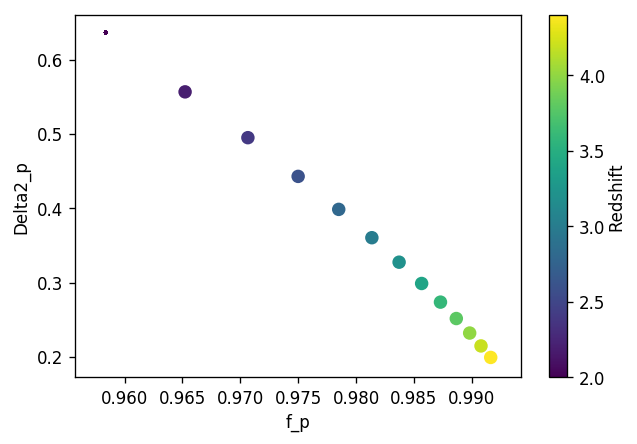

In [8]:
overplot_parameter_pair(arxiv,emu_calls,'f_p','Delta2_p',zs)

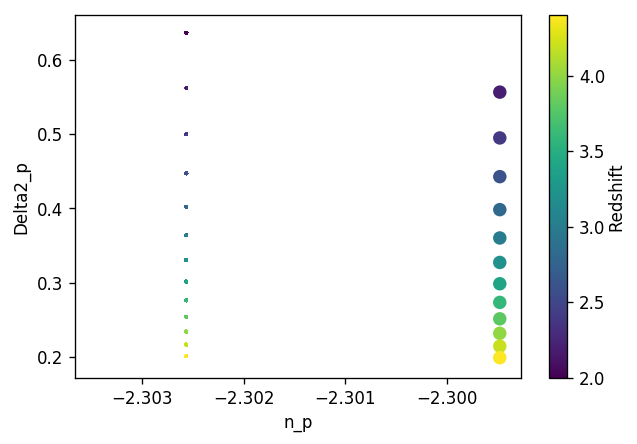

In [9]:
overplot_parameter_pair(arxiv,emu_calls,'n_p','Delta2_p',zs)

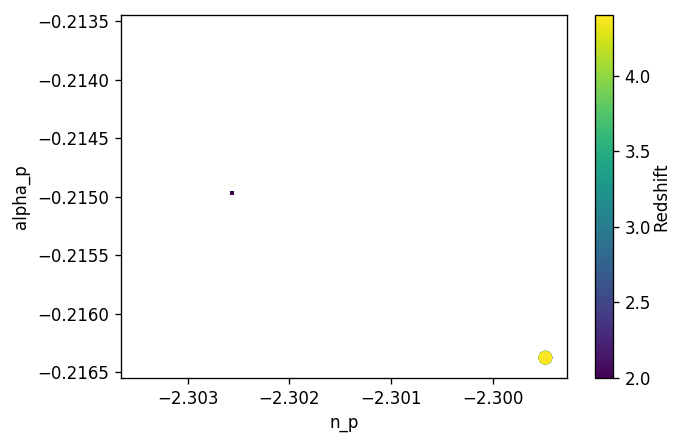

In [10]:
overplot_parameter_pair(arxiv,emu_calls,'n_p','alpha_p',zs)

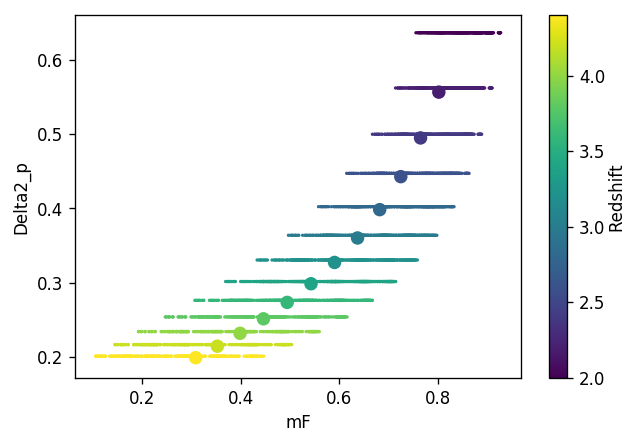

In [11]:
overplot_parameter_pair(arxiv,emu_calls,'mF','Delta2_p',zs=zs,drop_rescaled_tau=False)

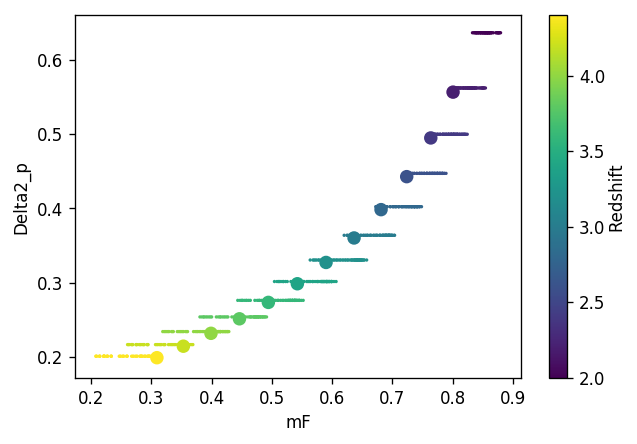

In [12]:
overplot_parameter_pair(arxiv,emu_calls,'mF','Delta2_p',zs=zs,drop_rescaled_tau=True)

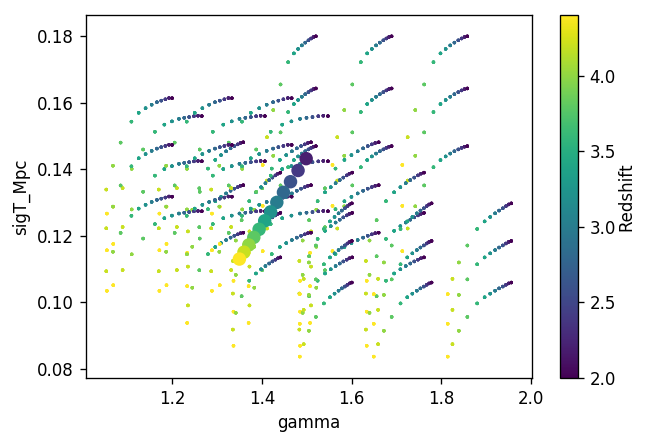

In [13]:
overplot_parameter_pair(arxiv,emu_calls,'gamma','sigT_Mpc',zs,drop_rescaled_temp=False)

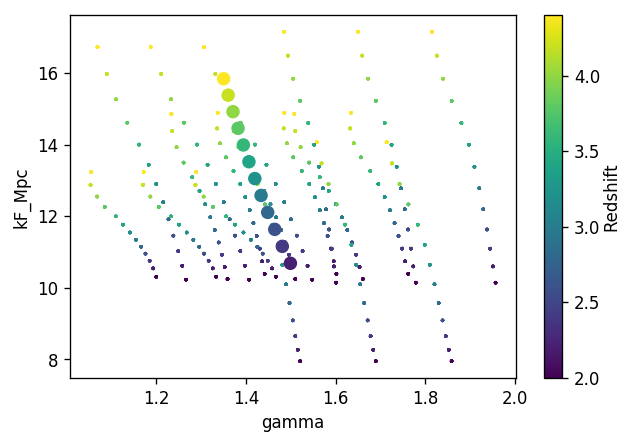

In [14]:
overplot_parameter_pair(arxiv,emu_calls,'gamma','kF_Mpc',zs,drop_rescaled_temp=False)

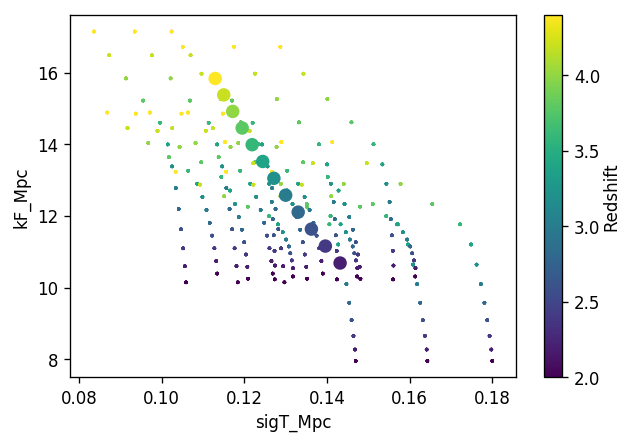

In [15]:
overplot_parameter_pair(arxiv,emu_calls,'sigT_Mpc','kF_Mpc',zs,drop_rescaled_temp=False)